# Summarize the extracted ToxCast endpoints

In [26]:
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
cell_info = pl.read_parquet("../../1_snakemake/inputs/annotations/toxcast_cellbased_info.parquet")
cellfree_info = pl.read_parquet("../../1_snakemake/inputs/annotations/toxcast_cellfree_info.parquet")
cytotox_info = pl.read_parquet("../../1_snakemake/inputs/annotations/toxcast_cytotox_info.parquet")
cytotox_info = cytotox_info.select(["cytotox_source_type", "cytotox_source"]).unique()

cell_binary = pl.read_parquet("../../1_snakemake/inputs/annotations/toxcast_cellbased_binary.parquet")
cellfree_binary = pl.read_parquet("../../1_snakemake/inputs/annotations/toxcast_cellfree_binary.parquet")
cytotox_binary = pl.read_parquet("../../1_snakemake/inputs/annotations/toxcast_cytotox_binary.parquet")

In [3]:
oasis_cmpds = cell_binary.select("OASIS_ID").to_series().unique().to_list() + cellfree_binary.select("OASIS_ID").to_series().unique().to_list() + cytotox_binary.select("OASIS_ID").to_series().unique().to_list()
oasis_cmpds = list(set(oasis_cmpds))
print(len(oasis_cmpds))

963


## Summarize extracted assays

In [4]:
# Compute stats for cell-based assays
cols = [i for i in cell_binary.columns if "OASIS_ID" not in i]
cell_stats = []
for col in cols:
    pos = cell_binary.filter(pl.col(col) == 1).shape[0]
    neg = cell_binary.filter(pl.col(col) == 0).shape[0]
    total = pos + neg

    cell_stats.append(pl.DataFrame({
        "assay_component_endpoint_name": col,
        "Num_pos": pos,
        "Num_neg": neg,
        "Total": total,
        "Percent_positive": pos/total
    }))

cell_stats = pl.concat(cell_stats)

In [5]:
# Compute stats for cell-free assays
cols = [i for i in cellfree_binary.columns if "OASIS_ID" not in i]
cellfree_stats = []
for col in cols:
    pos = cellfree_binary.filter(pl.col(col) == 1).shape[0]
    neg = cellfree_binary.filter(pl.col(col) == 0).shape[0]
    total = pos + neg

    cellfree_stats.append(pl.DataFrame({
        "assay_component_endpoint_name": col,
        "Num_pos": pos,
        "Num_neg": neg,
        "Total": total,
        "Percent_positive": pos/total
    }))

cellfree_stats = pl.concat(cellfree_stats)

In [6]:
# Compute stats for cytotox assays
cols = [i for i in cytotox_binary.columns if "OASIS_ID" not in i]
cytotox_stats = []
for col in cols:
    pos = cytotox_binary.filter(pl.col(col) == 1).shape[0]
    neg = cytotox_binary.filter(pl.col(col) == 0).shape[0]
    total = pos + neg

    cytotox_stats.append(pl.DataFrame({
        "assay_component_endpoint_name": f"{col}_cytotox",
        "Num_pos": pos,
        "Num_neg": neg,
        "Total": total,
        "Percent_positive": pos/total
    }))

cytotox_stats = pl.concat(cytotox_stats)

In [7]:
# plot stats
cell_stats = cell_stats.with_columns(pl.lit("cell_based").alias("assay_type"))
cellfree_stats = cellfree_stats.with_columns(pl.lit("cell_free").alias("assay_type"))
cytotox_stats = cytotox_stats.with_columns(pl.lit("cytotox").alias("assay_type"))

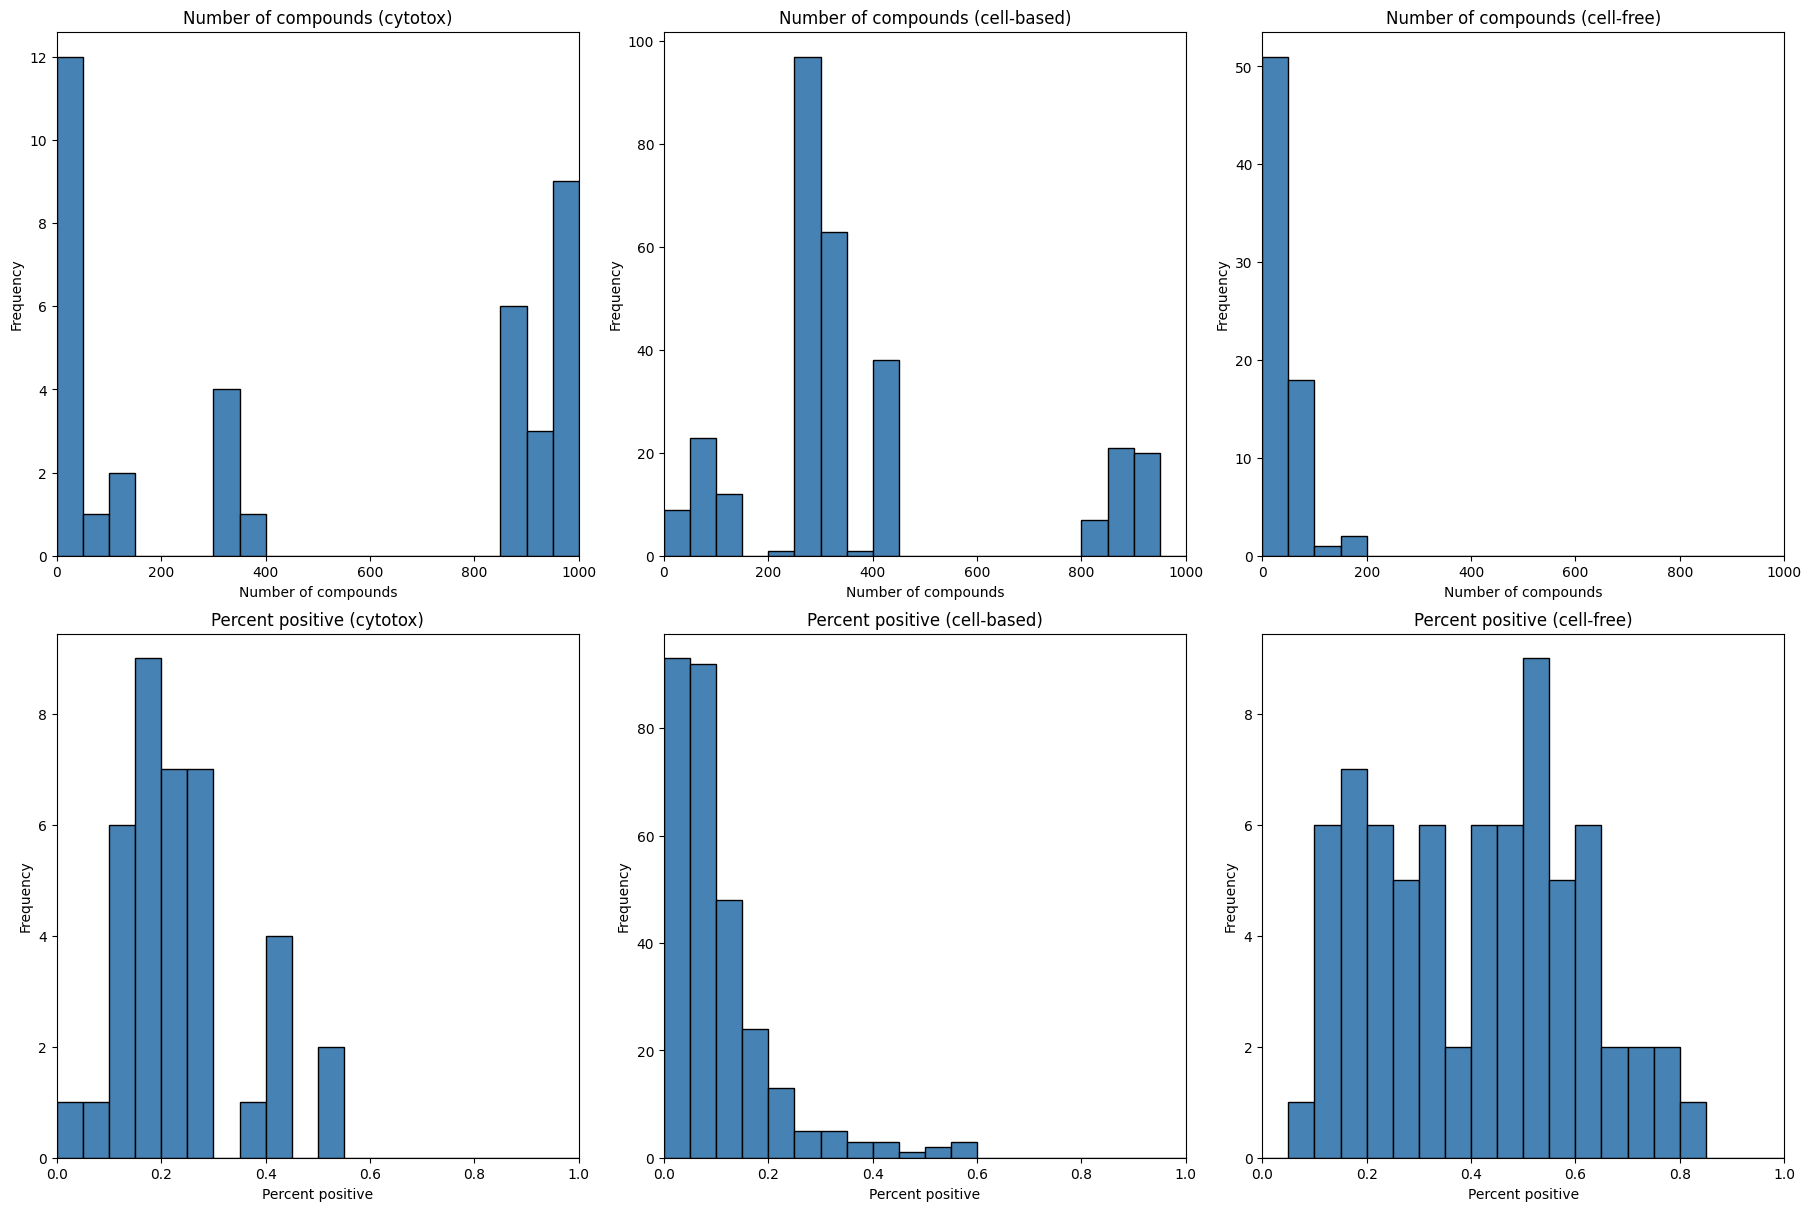

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12), constrained_layout=True)

axes[0, 0].hist(cytotox_stats["Total"], bins=20, color="steelblue", edgecolor="black", range=(0, 1000))
axes[0, 0].set_title("Number of compounds (cytotox)")
axes[0, 0].set_xlabel("Number of compounds")
axes[0, 0].set_ylabel("Frequency")
axes[0, 0].set_xlim(0, 1000)

axes[0, 1].hist(cell_stats["Total"], bins=20, color="steelblue", edgecolor="black", range=(0, 1000))
axes[0, 1].set_title("Number of compounds (cell-based)")
axes[0, 1].set_xlabel("Number of compounds")
axes[0, 1].set_ylabel("Frequency")
axes[0, 1].set_xlim(0, 1000)

axes[0, 2].hist(cellfree_stats["Total"], bins=20, color="steelblue", edgecolor="black", range=(0, 1000))
axes[0, 2].set_title("Number of compounds (cell-free)")
axes[0, 2].set_xlabel("Number of compounds")
axes[0, 2].set_ylabel("Frequency")
axes[0, 2].set_xlim(0, 1000)


axes[1, 0].hist(cytotox_stats["Percent_positive"], bins=20, color="steelblue", edgecolor="black", range=(0, 1))
axes[1, 0].set_title("Percent positive (cytotox)")
axes[1, 0].set_xlabel("Percent positive")
axes[1, 0].set_ylabel("Frequency")
axes[1, 0].set_xlim(0, 1)

axes[1, 1].hist(cell_stats["Percent_positive"], bins=20, color="steelblue", edgecolor="black", range=(0, 1))
axes[1, 1].set_title("Percent positive (cell-based)")
axes[1, 1].set_xlabel("Percent positive")
axes[1, 1].set_ylabel("Frequency")
axes[1, 1].set_xlim(0, 1)

axes[1, 2].hist(cellfree_stats["Percent_positive"], bins=20, color="steelblue", edgecolor="black", range=(0, 1))
axes[1, 2].set_title("Percent positive (cell-free)")
axes[1, 2].set_xlabel("Percent positive")
axes[1, 2].set_ylabel("Frequency")
axes[1, 2].set_xlim(0, 1)

plt.show()

In [62]:
print(f"Median % positive in cell-based: {str(cell_stats.select(pl.col('Percent_positive').median()).item())}")
print(f"Median % positive in cell-free: {str(cellfree_stats.select(pl.col('Percent_positive').median()).item())}")
print(f"Median % positive in cytotox: {str(cytotox_stats.select(pl.col('Percent_positive').median()).item())}")

print(f"Median cmpd # in cell-based: {str(cell_stats.select(pl.col('Total').median()).item())}")
print(f"Median cmpd # in cell-free: {str(cellfree_stats.select(pl.col('Total').median()).item())}")
print(f"Median cmpd # in cytotox: {str(cytotox_stats.select(pl.col('Total').median()).item())}")

Median % positive in cell-based: 0.071161355334425
Median % positive in cell-free: 0.4134295227524972
Median % positive in cytotox: 0.20683488012374324
Median cmpd # in cell-based: 306.0
Median cmpd # in cell-free: 33.0
Median cmpd # in cytotox: 346.0


In [8]:
cellfree_info = cellfree_info.select([
    "assay_component_endpoint_name",
    "assay_function_type",
    "intended_target_family",
    "intended_target_family_sub"
]).unique().filter(
    pl.col("assay_component_endpoint_name").is_in(cellfree_stats.select("assay_component_endpoint_name").to_series().to_list())
)

In [9]:
cell_info = cell_info.select([
    "assay_component_endpoint_name",
    "tissue",
    "cell_short_name",
    "intended_target_type",
    "intended_target_family",
    "intended_target_family_sub"
]).unique().filter(
    pl.col("assay_component_endpoint_name").is_in(cell_stats.select("assay_component_endpoint_name").to_series().to_list())
)

In [10]:
# overall summary
print(f"Cell-free assays: {str(cellfree_info.shape[0])}")
print(f"Cell-based assays: {str(cell_info.shape[0])}")
print(f"Cytotoxicty assays: {str(cytotox_info.shape[0])}")

Cell-free assays: 72
Cell-based assays: 292
Cytotoxicty assays: 48


### Print out summaries of cytotoxicty assays

In [11]:
print(f"Cell types: {str(cytotox_info.filter(pl.col('cytotox_source_type') == 'cell_type').shape[0])}")
print(f"Tissues: {str(cytotox_info.filter(pl.col('cytotox_source_type') == 'tissue').shape[0])}")

Cell types: 28
Tissues: 20


### Print out summaries of cell-based assays

In [12]:
tissue = cell_info.select(pl.col("tissue").value_counts()).unnest("tissue").sort("count", descending=True)
print(f"Unique tissues in cell-based assays: {str(tissue.shape[0])}")
tissue = tissue.with_columns(
    (pl.col("count")/cell_info.shape[0]).alias("percent")
)
tissue

Unique tissues in cell-based assays: 14


tissue,count,percent
str,u32,f64
"""liver""",151,0.517123
"""vascular""",63,0.215753
"""kidney""",35,0.119863
"""adrenal gland""",12,0.041096
"""breast""",9,0.030822
"""cervix""",7,0.023973
"""intestinal""",5,0.017123
"""mammary gland/…",2,0.006849
"""prostate""",2,0.006849


In [13]:
celltypes = cell_info.select(pl.col("cell_short_name").value_counts()).unnest("cell_short_name").sort("count", descending=True)
print(f"Unique cell types in cell-based assays: {str(celltypes.shape[0])}")
celltypes = celltypes.with_columns(
    (pl.col("count")/cell_info.shape[0]).alias("percent")
)
celltypes

Unique cell types in cell-based assays: 27


cell_short_name,count,percent
str,u32,f64
"""HepaRG""",90,0.308219
"""HepG2""",54,0.184932
"""HEK293T""",28,0.09589
"""umbilical vein…",20,0.068493
"""umbilical vein…",17,0.058219
"""H295R""",12,0.041096
"""coronary arter…",12,0.041096
"""hepatocyte""",7,0.023973
"""lung fibroblas…",7,0.023973


In [14]:
target_type = cell_info.select(pl.col("intended_target_type").value_counts()).unnest("intended_target_type").sort("count", descending=True)
print(f"Unique target types in cell-based assays: {str(target_type.shape[0])}")
target_type = target_type.with_columns(
    (pl.col("count")/cell_info.shape[0]).alias("percent")
)
print(target_type)

Unique target types in cell-based assays: 6
shape: (6, 3)
┌──────────────────────┬───────┬──────────┐
│ intended_target_type ┆ count ┆ percent  │
│ ---                  ┆ ---   ┆ ---      │
│ str                  ┆ u32   ┆ f64      │
╞══════════════════════╪═══════╪══════════╡
│ protein              ┆ 135   ┆ 0.462329 │
│ rna                  ┆ 96    ┆ 0.328767 │
│ pathway              ┆ 33    ┆ 0.113014 │
│ cellular             ┆ 15    ┆ 0.05137  │
│ molecular messenger  ┆ 12    ┆ 0.041096 │
│ dna                  ┆ 1     ┆ 0.003425 │
└──────────────────────┴───────┴──────────┘


In [15]:
target_family = cell_info.select(pl.col("intended_target_family").value_counts()).unnest("intended_target_family").sort("count", descending=True)
print(f"Unique target families in cell-based assays: {str(target_family.shape[0])}")
target_family = target_family.with_columns(
    (pl.col("count")/cell_info.shape[0]).alias("percent")
)
print(target_family)

Unique target families in cell-based assays: 36
shape: (36, 3)
┌────────────────────────┬───────┬──────────┐
│ intended_target_family ┆ count ┆ percent  │
│ ---                    ┆ ---   ┆ ---      │
│ str                    ┆ u32   ┆ f64      │
╞════════════════════════╪═══════╪══════════╡
│ nuclear receptor       ┆ 56    ┆ 0.191781 │
│ dna binding            ┆ 54    ┆ 0.184932 │
│ cytokine               ┆ 32    ┆ 0.109589 │
│ cell cycle             ┆ 18    ┆ 0.061644 │
│ …                      ┆ …     ┆ …        │
│ filaments              ┆ 1     ┆ 0.003425 │
│ growth factor receptor ┆ 1     ┆ 0.003425 │
│ microrna               ┆ 1     ┆ 0.003425 │
│ immunoglobulin         ┆ 1     ┆ 0.003425 │
└────────────────────────┴───────┴──────────┘


### Print out summaries of cell-free assays

In [16]:
target_family = cellfree_info.select(pl.col("intended_target_family").value_counts()).unnest("intended_target_family").sort("count", descending=True)
print(f"Unique target families in cell-free assays: {str(target_family.shape[0])}")
target_family = target_family.with_columns(
    (pl.col("count")/cellfree_info.shape[0]).alias("percent")
)
print(target_family)

Unique target families in cell-free assays: 11
shape: (11, 3)
┌────────────────────────┬───────┬──────────┐
│ intended_target_family ┆ count ┆ percent  │
│ ---                    ┆ ---   ┆ ---      │
│ str                    ┆ u32   ┆ f64      │
╞════════════════════════╪═══════╪══════════╡
│ gpcr                   ┆ 21    ┆ 0.291667 │
│ cyp                    ┆ 11    ┆ 0.152778 │
│ nuclear receptor       ┆ 10    ┆ 0.138889 │
│ protease               ┆ 7     ┆ 0.097222 │
│ …                      ┆ …     ┆ …        │
│ phosphatase            ┆ 3     ┆ 0.041667 │
│ hydrolase              ┆ 2     ┆ 0.027778 │
│ dehalogenase           ┆ 1     ┆ 0.013889 │
│ ion channel            ┆ 1     ┆ 0.013889 │
└────────────────────────┴───────┴──────────┘


In [17]:
assay_function_type = cellfree_info.select(pl.col("assay_function_type").value_counts()).unnest("assay_function_type").sort("count", descending=True)
print(f"Unique assay_function_type in cell-free assays: {str(assay_function_type.shape[0])}")
assay_function_type = assay_function_type.with_columns(
    (pl.col("count")/cellfree_info.shape[0]).alias("percent")
)
print(assay_function_type)

Unique assay_function_type in cell-free assays: 2
shape: (2, 3)
┌─────────────────────┬───────┬──────────┐
│ assay_function_type ┆ count ┆ percent  │
│ ---                 ┆ ---   ┆ ---      │
│ str                 ┆ u32   ┆ f64      │
╞═════════════════════╪═══════╪══════════╡
│ binding             ┆ 37    ┆ 0.513889 │
│ enzymatic activity  ┆ 35    ┆ 0.486111 │
└─────────────────────┴───────┴──────────┘


In [18]:
intended_target_family_sub = cellfree_info.select(pl.col("intended_target_family_sub").value_counts()).unnest("intended_target_family_sub").sort("count", descending=True)
print(f"Unique intended_target_family_sub in cell-free assays: {str(intended_target_family_sub.shape[0])}")
intended_target_family_sub = intended_target_family_sub.with_columns(
    (pl.col("count")/cellfree_info.shape[0]).alias("percent")
)
print(intended_target_family_sub)

Unique intended_target_family_sub in cell-free assays: 23
shape: (23, 3)
┌───────────────────────────────────┬───────┬──────────┐
│ intended_target_family_sub        ┆ count ┆ percent  │
│ ---                               ┆ ---   ┆ ---      │
│ str                               ┆ u32   ┆ f64      │
╞═══════════════════════════════════╪═══════╪══════════╡
│ rhodopsin-like receptor           ┆ 21    ┆ 0.291667 │
│ xenobiotic metabolism             ┆ 10    ┆ 0.138889 │
│ non-steroidal                     ┆ 6     ┆ 0.083333 │
│ matrix metalloproteinase          ┆ 4     ┆ 0.055556 │
│ …                                 ┆ …     ┆ …        │
│ phosphoinositol kinase            ┆ 1     ┆ 0.013889 │
│ pseudocholinesterase              ┆ 1     ┆ 0.013889 │
│ cholesterol transporter           ┆ 1     ┆ 0.013889 │
│ non-receptor tyrosine phosphatas… ┆ 1     ┆ 0.013889 │
└───────────────────────────────────┴───────┴──────────┘


## Compute how many positive hits were filtered out by cytotoxicity

In [19]:
cell_binary_filter = pl.read_parquet("../../1_snakemake/inputs/annotations/toxcast_cellbased_binary.parquet")
cell_binary_filter = cell_binary_filter.melt(
    id_vars = "OASIS_ID"
)

# recompute binary hit calls without cytotox filter
cell_results = pl.read_parquet("../../1_snakemake/inputs/annotations/toxcast_cellbased_info.parquet")
cell_binary = cell_results.select([
    "OASIS_ID", "assay_component_endpoint_name", "hitcall", "ac50", "cytotox_median_ac50"
]).with_columns(
    (pl.col("hitcall") > 0.9).cast(pl.Int64).alias("hitcall"),
    (pl.col("cytotox_median_ac50")).fill_null(999999).alias("cytotox_median_ac50")
)

# Sometimes there are multiple results for the same chemical-assay combo. Use majority hitcall as the hitcall. Ties go to no hit.
aggregated_df = (
    cell_binary.group_by(["OASIS_ID", "assay_component_endpoint_name"])
    .agg([
        (
            (pl.col("hitcall").sum() > (pl.count() // 2))
            .cast(pl.Int64)
            .alias("hitcall")
        )
    ])
)
cell_binary = cell_binary.select(["OASIS_ID", "assay_component_endpoint_name"]).unique()
cell_binary = cell_binary.join(aggregated_df, on=["OASIS_ID", "assay_component_endpoint_name"])

# pivot to one column per assay
cell_binary = cell_binary.pivot(
    values="hitcall",
    index="OASIS_ID",
    columns="assay_component_endpoint_name",
)

# only keep assays with at least 5 positive and 5 negative classes
def has_min_zeros_and_ones(col):
    return (col == 0).sum() >= 5 and (col == 1).sum() >= 5

cell_binary = cell_binary.select(
    ["OASIS_ID"] + [
        col for col in cell_binary.columns if col != "OASIS_ID" and has_min_zeros_and_ones(cell_binary[col])
    ]
)

cell_binary = cell_binary.melt(
    id_vars = "OASIS_ID"
)

In [20]:
print(cell_binary.filter(pl.col("value") == 1).shape[0] / cell_binary.shape[0])
print(cell_binary_filter.filter(pl.col("value") == 1).shape[0] / cell_binary_filter.shape[0])

0.060847238225294815
0.0298724021678829


In [21]:
print(cell_binary.filter(pl.col("value") == 1).shape[0])
print(cell_binary_filter.filter(pl.col("value") == 1).shape[0])

17110
8400


## Compare cytotoxicity values across cell types

In [32]:
cytotox = pl.read_parquet("../../1_snakemake/inputs/annotations/toxcast_cytotox_info.parquet")

# count number of compounds per cell
cytotox_per_cell = cytotox.filter(pl.col("cytotox_source_type") == "cell_type").select(pl.col("assay_label").value_counts()).unnest("assay_label").sort("count", descending=True)
keep_cell_types = cytotox_per_cell.filter(pl.col("count") > 800).select("assay_label").to_series().to_list()

cytotox = cytotox.filter(pl.col("assay_label").is_in(keep_cell_types)).with_columns(
    pl.when(pl.col("cytotox_median_ac50").is_null()).then(pl.lit(100)).otherwise(pl.col("cytotox_median_ac50")).alias("cytotox_median_ac50")
)

duplicate_counts = (
    cytotox.group_by(["OASIS_ID", "assay_label"])
    .agg(pl.count("cytotox_median_ac50").alias("count"))
    .filter(pl.col("count") > 1)  # Keep only groups with duplicates
)

cytotox_comp = cytotox.pivot(
    values="cytotox_median_ac50",
    index="OASIS_ID",
    columns="assay_label",
    aggregate_function="first"
)

There are 12 cell types that have cytotoxicity assays for more than 800 OASIS compounds.

/home/jewald/repos/2024_09_09_Axiom_OASIS/axiom/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 96 rows containing missing values.


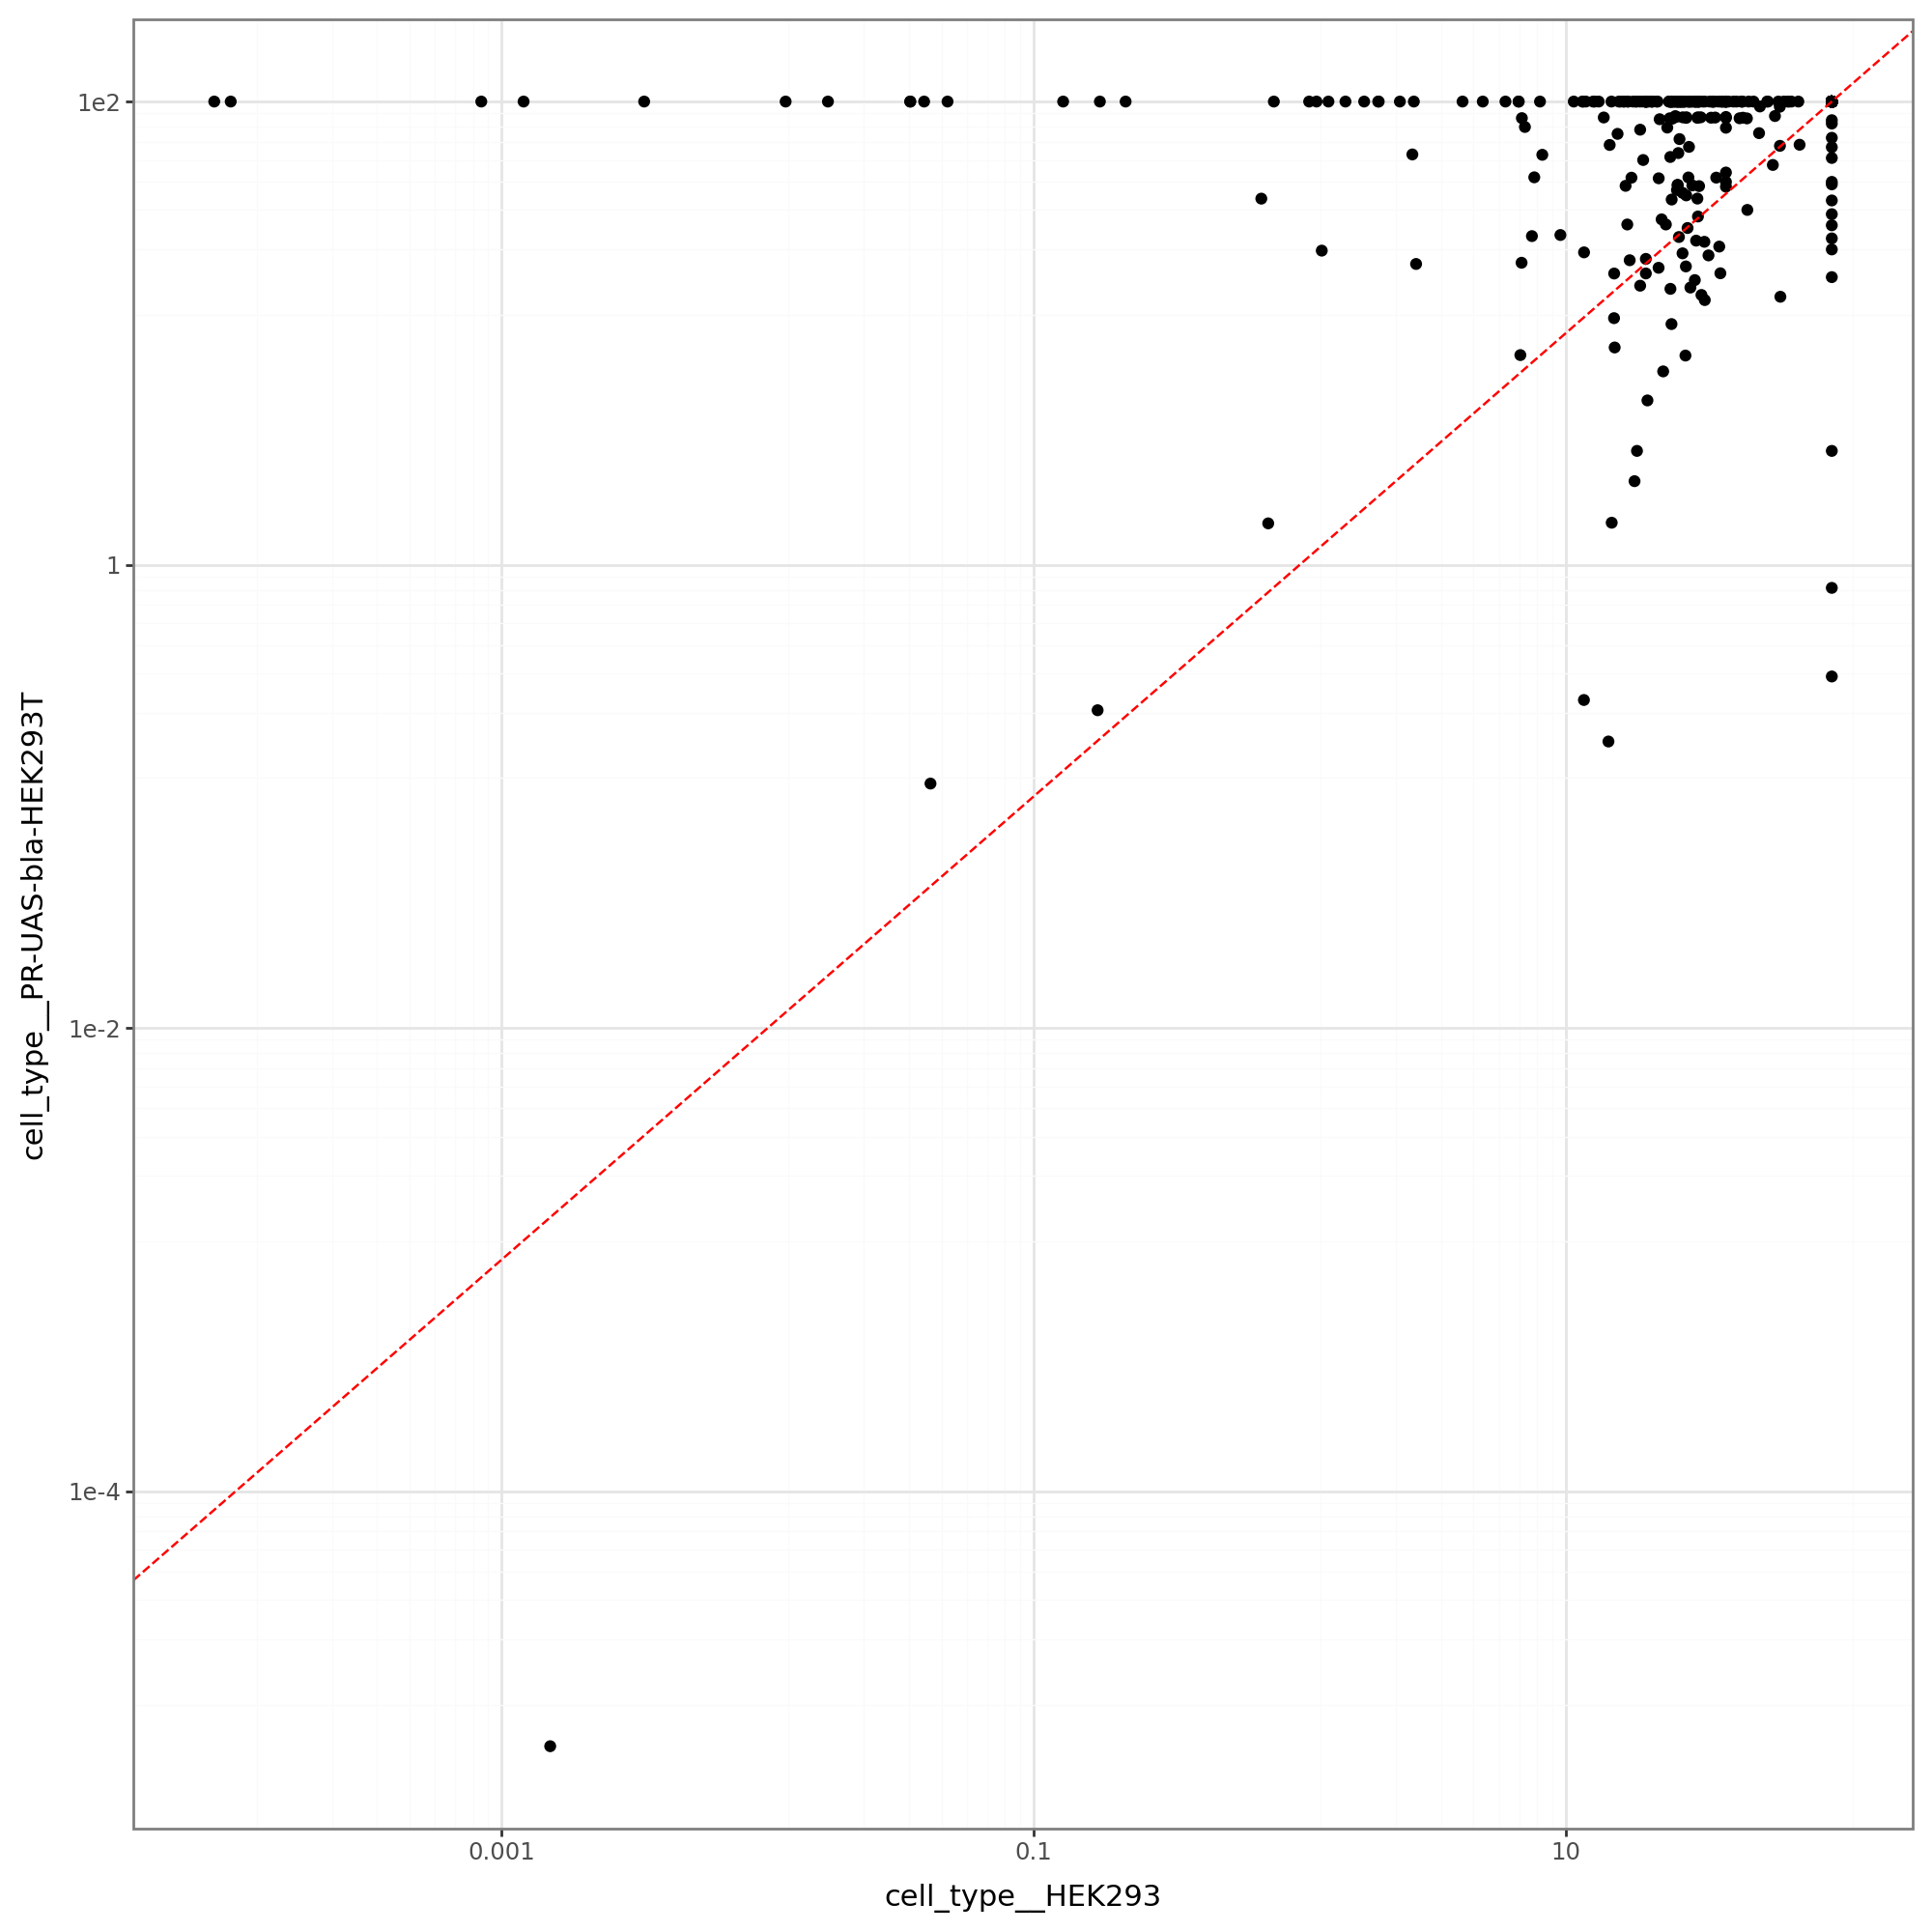

In [33]:
from plotnine import ggplot, aes, geom_point, theme_bw, scale_x_log10, scale_y_log10, geom_abline

import plotnine as pn 

pn.options.figure_size = (10, 10)

cell_1 = "cell_type__HEK293"
cell_2 = "cell_type__PR-UAS-bla-HEK293T"

plot1 = (ggplot(cytotox_comp) + aes(x=cell_1, y=cell_2) +
         geom_point() + theme_bw() + 
         geom_abline(intercept=0, slope=1, linetype="dashed", color="red") + 
         scale_x_log10() + scale_y_log10())

plot1.show()

/home/jewald/repos/2024_09_09_Axiom_OASIS/axiom/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
/home/jewald/repos/2024_09_09_Axiom_OASIS/axiom/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.


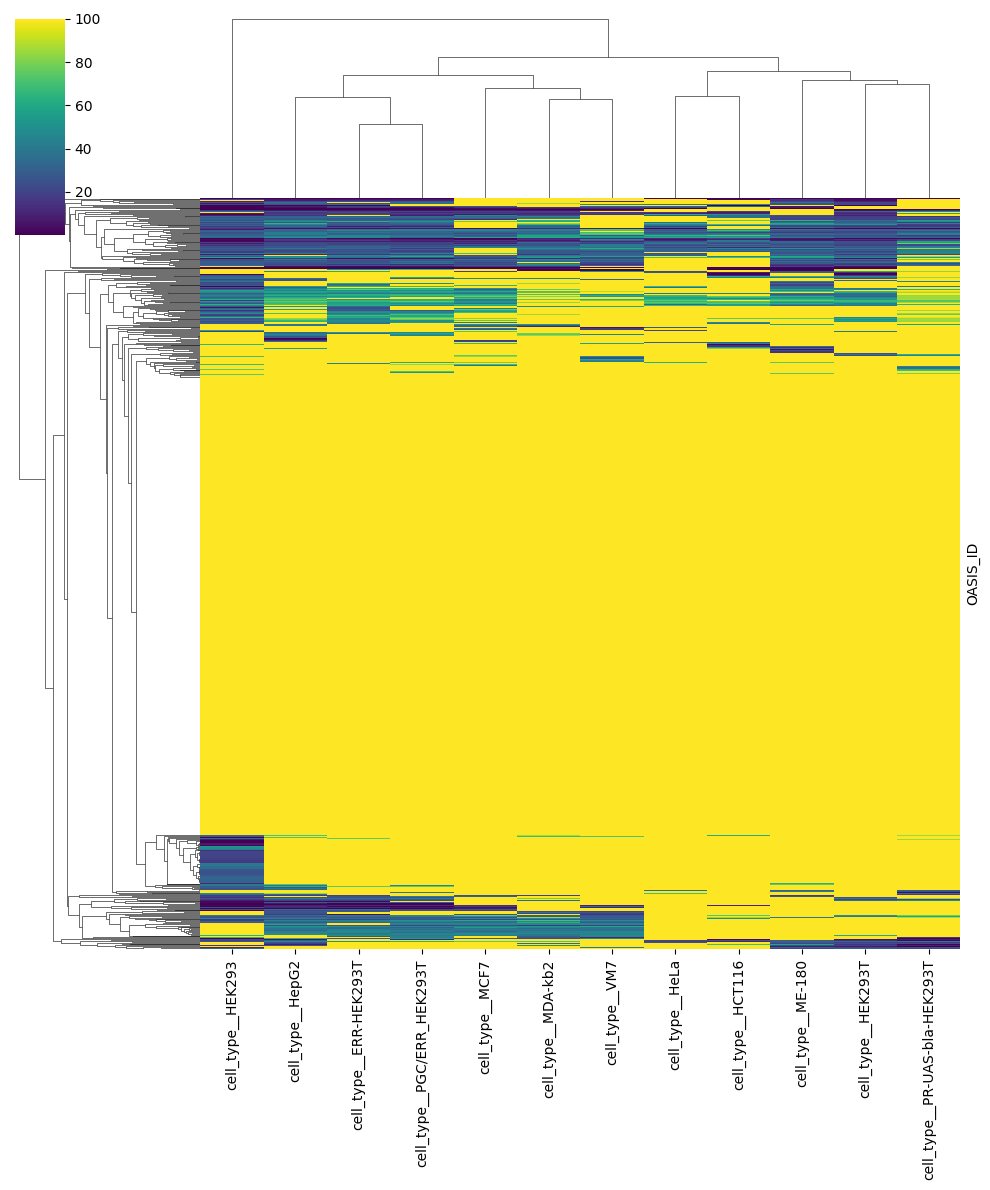

In [35]:
df = cytotox_comp.to_pandas().dropna()
df.set_index("OASIS_ID", inplace=True)

sns.clustermap(
    df,
    metric="euclidean",
    method="average",
    cmap="viridis",
    figsize=(10, 12),
    dendrogram_ratio=(0.2, 0.2),
    cbar_pos=(0.02, 0.8, 0.05, 0.18),
    row_cluster=True,
    col_cluster=True,
    xticklabels=True,
    yticklabels=False
    )

plt.show()

In [37]:
# Make heatmap for tissue-level
cytotox = pl.read_parquet("../../1_snakemake/inputs/annotations/toxcast_cytotox_info.parquet")

# count number of compounds per cell
cytotox_per_tissue = cytotox.filter(pl.col("cytotox_source_type") == "tissue").select(pl.col("assay_label").value_counts()).unnest("assay_label").sort("count", descending=True)
keep_tissue_types = cytotox_per_tissue.filter(pl.col("count") > 800).select("assay_label").to_series().to_list()

cytotox = cytotox.filter(pl.col("assay_label").is_in(keep_tissue_types)).with_columns(
    pl.when(pl.col("cytotox_median_ac50").is_null()).then(pl.lit(100)).otherwise(pl.col("cytotox_median_ac50")).alias("cytotox_median_ac50")
)

duplicate_counts = (
    cytotox.group_by(["OASIS_ID", "assay_label"])
    .agg(pl.count("cytotox_median_ac50").alias("count"))
    .filter(pl.col("count") > 1)  # Keep only groups with duplicates
)

cytotox_comp = cytotox.pivot(
    values="cytotox_median_ac50",
    index="OASIS_ID",
    columns="assay_label",
    aggregate_function="first"
)

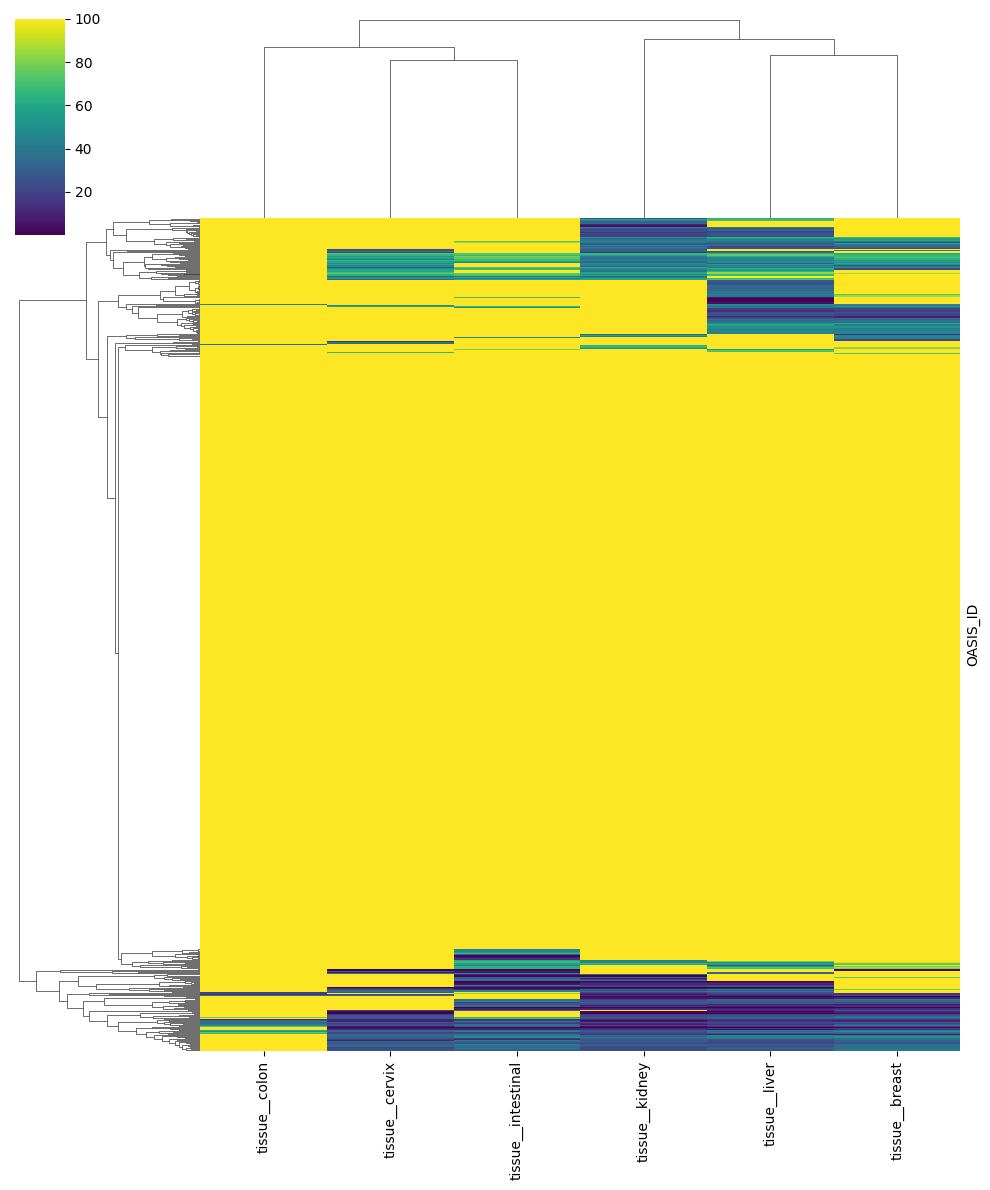

In [38]:
df = cytotox_comp.to_pandas().dropna()
df.set_index("OASIS_ID", inplace=True)

sns.clustermap(
    df,
    metric="euclidean",
    method="average",
    cmap="viridis",
    figsize=(10, 12),
    dendrogram_ratio=(0.2, 0.2),
    cbar_pos=(0.02, 0.8, 0.05, 0.18),
    row_cluster=True,
    col_cluster=True,
    xticklabels=True,
    yticklabels=False
    )

plt.show()